In [1]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import os
import tensorflow as tf

import random
random.seed(42)

2025-07-12 13:23:06.784302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752351786.798518  505399 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752351786.802882  505399 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752351786.815763  505399 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752351786.815776  505399 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752351786.815778  505399 computation_placer.cc:177] computation placer alr

In [2]:
# minorized reference
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    #print("Keys: %s" % file.keys())
    ref_d = file['density'][:]
#print(ref_d)
print(ref_d.shape)
minorized_ref_d = (np.sum(ref_d,axis=2))
minorized_ref_d.shape



(64, 64, 64)


(64, 64)

In [4]:
####################################################################################################################################################
def stochastic_density(d,N):
    # poisson model
    #  accurate and fast for all values of N
    # N  = number of MC samples
    assert isinstance(d,np.ndarray)
    assert isinstance(N,(int,float,np.int64,np.float64))
    assert N>0
    ds = np.random.poisson(N*d)/N
    ds*= d.sum()/ds.sum()
    return ds
#end def stochastic_density

####################################################################################################################################################

In [5]:
def generate_single_2d_density(ref_d, noise_level):
    noisy_3d = stochastic_density(ref_d, noise_level)  # shape: (64, 64, 64)
    projected_2d = np.sum(noisy_3d, axis=2)             # shape: (64, 64)
    return projected_2d
#!!!!!!!!!!!!!!!!!!! adjust these values to cahnge value range for JSD
# Noise levels to randomly draw from
noise_levels = [5000 * (j + 1) for j in range(5)] 
#set y noise for comparison
test_noise = 500000
y_noise = 5000000
# Sizes
num_train = 5000
num_val = 1000
num_test = 500

num_samples = 0 

# Generate train set with mixed noise levels
x_train = np.zeros((num_train, 64, 64))
for i in range(num_train):
    noise_level = np.random.choice(noise_levels)
    num_samples+=noise_level
    x_train[i] = generate_single_2d_density(ref_d, noise_level)
    

# Generate val set with mixed noise levels
x_val = np.zeros((num_val, 64, 64))
for i in range(num_val):
    noise_level = np.random.choice(noise_levels)
    num_samples+=noise_level
    x_val[i] = generate_single_2d_density(ref_d, noise_level)

# Generate test set with fixed noise level
x_test = np.zeros((num_test, 64, 64))
for i in range(num_test):
    x_test[i] = generate_single_2d_density(ref_d, test_noise)
    num_samples+=test_noise

print("Train, val, test generated")


# Average over all

total_ex = num_train + num_val + num_test
train_sum = np.sum(x_train, axis=0)
val_sum = np.sum(x_val, axis=0)
test_sum = np.sum(x_test, axis=0)
AVG_TOTAL = (train_sum + val_sum + test_sum) / total_ex

np.save(str(num_samples)+'_sample_density', AVG_TOTAL)


Train, val, test generated


In [6]:

y_test_3d = np.zeros((x_test.shape[0],64,64,64))
y_train_3d = np.zeros((x_train.shape[0],64,64,64))
y_val_3d = np.zeros((x_val.shape[0],64,64,64))
for i in range (y_test_3d.shape[0]):
    y_test_3d[i]=stochastic_density(ref_d,y_noise)
y_test = (np.sum(y_test_3d,axis=2))

for i in range (y_train_3d.shape[0]):
    y_train_3d[i]=stochastic_density(ref_d,y_noise)
y_train = (np.sum(y_train_3d,axis=2))

for i in range (y_val_3d.shape[0]):
    y_val_3d[i]=stochastic_density(ref_d,y_noise)
y_val = (np.sum(y_val_3d,axis=2))
print("here")



here


In [7]:
# Add channel dimension
x_train = x_train[..., np.newaxis]
x_val   = x_val[..., np.newaxis]
x_test  = x_test[..., np.newaxis]

y_train = y_train[..., np.newaxis]
y_val   = y_val[..., np.newaxis]
y_test   = y_test[..., np.newaxis]

In [8]:
import tensorflow as tf

def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)

    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)

    jsd = 0.5 * (kl_true + kl_pred)

    return tf.reduce_mean(jsd)


In [9]:
# must beat the model predicting the average
test_avg = np.mean(x_test[:,:,:,0],axis=0)
print("2 norm difference")
print("Mean vs DFT 2 norm diff")
print(np.linalg.norm(test_avg-minorized_ref_d))


print("divergence difference")              
print("JSD (bar{x_test},y_dft):", jensen_shannon_divergence_loss(test_avg, minorized_ref_d.copy()))

# should be on the order of 1.4 10^-5

2 norm difference
Mean vs DFT 2 norm diff
0.00018352076058496535
divergence difference
JSD (bar{x_test},y_dft): tf.Tensor(3.1029555e-07, shape=(), dtype=float32)


2025-07-12 13:26:13.379518: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0479 - val_loss: 0.0472
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0458 - val_loss: 0.0324
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0219 - val_loss: 0.0027
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0019 - val_loss: 6.8518e-04
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.4411e-04 - val_loss: 2.7262e-04
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.2975e-04 - val_loss: 1.3860e-04
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2170e-04 - val_loss: 8.3282e-05
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.5191e-05 - val_loss: 5.5738e-05
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.1329e-05 - val_loss: 4.0411e-05
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.7855e-05 - val_loss: 3.1448e-05
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.9902e-05 - va

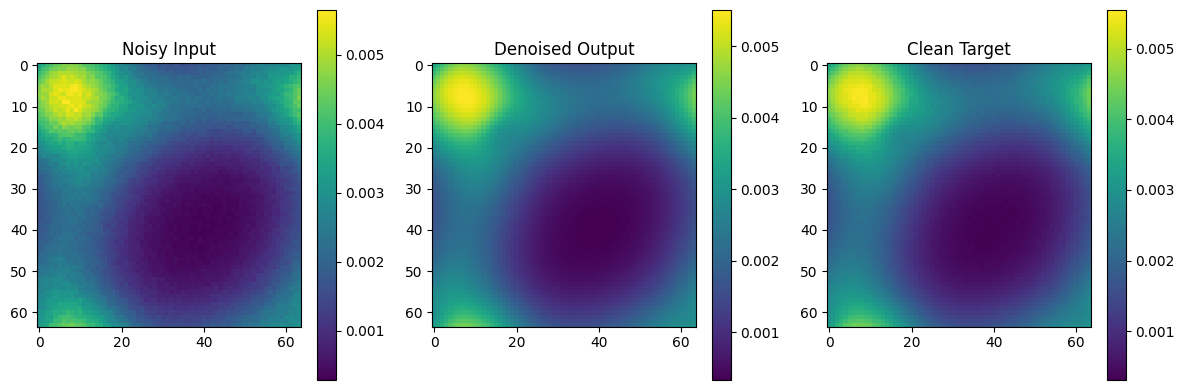

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
from tensorflow.keras.utils import register_keras_serializable


# --- Custom Renormalization Layer ---
@register_keras_serializable(package="Custom")
class Renormalize(tf.keras.layers.Layer):
    def __init__(self, target_sum=8.0, **kwargs):
        super().__init__(**kwargs)
        self.target_sum = target_sum

    def call(self, inputs):
        x_sum = tf.reduce_sum(inputs, axis=[1, 2, 3], keepdims=True)
        return inputs / (x_sum + 1e-8) * self.target_sum

    def get_config(self):
        config = super().get_config()
        config.update({'target_sum': self.target_sum})
        return config


# --- Custom JS Divergence Loss ---
@register_keras_serializable(package="Custom")


def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)

    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)

    jsd = 0.5 * (kl_true + kl_pred)

    return tf.reduce_mean(jsd)


# --- Create DAE Model ---
def create_dae(input_shape):
    flat_dim = np.prod(input_shape)
    model = tf.keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(flat_dim, activation='sigmoid'),
        layers.Reshape(target_shape=input_shape),
        Renormalize(target_sum=8.0)  # Use the custom layer here
    ])
    return model


# --- Main ---
if __name__ == '__main__':
    input_shape = (64, 64, 1)

    dae = create_dae(input_shape)
    dae.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                loss=jensen_shannon_divergence_loss)

    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    dae.fit(x_train.copy(), y_train.copy(),
            validation_data=(x_val.copy(), y_val.copy()),
            epochs=100,
            batch_size=50,
            callbacks=[early_stop],
            verbose=1)

    # --- Predict and Plot ---
    i = 0
    denoised_norm = dae.predict(x_test.copy()[i:i+1])[0, ..., 0]
    denoised = denoised_norm
    noisy_input = x_test.copy()[i, ..., 0]
    true_clean = y_test.copy()[i, ..., 0]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(noisy_input, cmap='viridis')
    plt.title("Noisy Input")
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(denoised, cmap='viridis')
    plt.title("Denoised Output")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow(true_clean, cmap='viridis')
    plt.title("Clean Target")
    plt.colorbar()

    plt.tight_layout()
    plt.show()


In [11]:
 dae.save(str(num_samples)+"_DAE.keras")


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - loss: 0.0320 - val_loss: 4.0401e-04 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 3.6584e-04 - val_loss: 2.6566e-04 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - loss: 2.5683e-04 - val_loss: 2.0435e-04 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - loss: 1.8584e-04 - val_loss: 1.3668e-04 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 1.4376e-04 - val_loss: 2.9694e-04 - learning_rate: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/20
157/157 ━

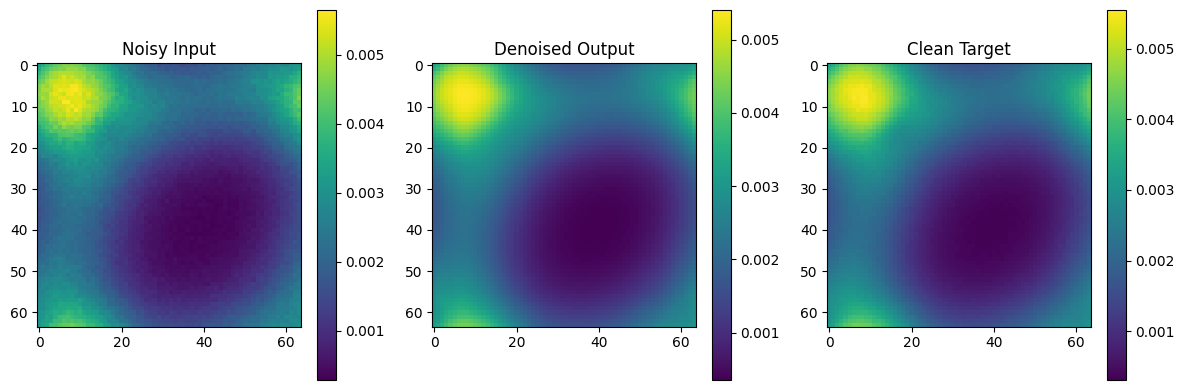

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import register_keras_serializable
import matplotlib.pyplot as plt

# === Custom Layer ===
@register_keras_serializable()
class Renormalize(layers.Layer):
    def __init__(self, target_sum=8.0, **kwargs):
        super().__init__(**kwargs)
        self.target_sum = target_sum

    def call(self, inputs):
        x_sum = tf.reduce_sum(inputs, axis=[1, 2, 3], keepdims=True)
        return inputs / (x_sum + 1e-8) * self.target_sum

    def get_config(self):
        config = super().get_config()
        config.update({'target_sum': self.target_sum})
        return config

# === Custom Loss ===
@register_keras_serializable()
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)

    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)

    jsd = 0.5 * (kl_true + kl_pred)

    return tf.reduce_mean(jsd)




# === Model Builder ===
def create_cae(input_shape, target_sum=8.0):
    input_layer = layers.Input(shape=input_shape)

    # Encoder with downsampling
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Bottleneck
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)

    # Decoder with upsampling
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Changed to sigmoid

    # Normalize to target sum
    output_layer = Renormalize(target_sum=target_sum)(x)

    return models.Model(inputs=input_layer, outputs=output_layer)

# Learning rate schedule
lr_schedule = callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * (0.5 ** (epoch // 10)),  # Halve LR every 10 epochs
    verbose=1
)

# === Main Execution ===
if __name__ == '__main__':
    input_shape = (64, 64, 1)


    cae = create_cae(input_shape)

    cae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=jensen_shannon_divergence_loss)

    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = cae.fit(x_train, y_train,
                  validation_data=(x_val, y_val),
                  epochs=20,
                  batch_size=32,
                  callbacks=[early_stop, lr_schedule],
                  shuffle=True,
                  verbose=1)


    cae.save("CAE.keras")

    # Predict and plot
    i = 0
    denoised = cae.predict(x_test[i:i+1])[0, ..., 0]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(x_test[i, ..., 0], cmap='viridis')
    plt.title("Noisy Input")
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(denoised, cmap='viridis')
    plt.title("Denoised Output")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow(y_test[i, ..., 0], cmap='viridis')
    plt.title("Clean Target")
    plt.colorbar()

    plt.tight_layout()
    plt.show()


In [13]:
cae.save(str(num_samples)+"_CAE.keras")

In [13]:
print("here")

here
